In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import FineSimpleConvNet, CustomNN
from common.optimizer import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import Augmentor
from keras.preprocessing import image
import pickle
import h5py


C:\Users\arakawa eito\anaconda3\envs\env-skillup\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class genSequence:
    """
    データセットのジェネレータ
    """
    def __init__(self, data_path, data_size, categoNum, X_name, y_name, batch_size, aug=False, augNum=None, idx=None):
        """
        idx:使用するHDF5datasetのインデックスのリスト(ndarray)（訓練データとテストデータで分けるときなど）
        categoNum：データのカテゴリ数
        augNum：batch_size+augNum個のデータをイテレートする
        
        """
        self.iterCount = 0         # イテレーション回数
        self.data_path = data_path #　HDF５の格納パス
        self.data_size = data_size #　データ数
        self.batch_size = batch_size
        self.X_name = X_name       # hdf5ファイルのdataset名
        self.y_name = y_name
        self.aug = aug
        self.augNum = augNum
        self.idx = idx
        self.categoNum = categoNum
        
        # 使用するデータをシャッフル
        if isinstance(self.idx, np.ndarray):
            self.data_size = len(self.idx)
            np.random.shuffle(self.idx)
        else:
        # 全データを使用する
            self.idx = np.arange(self.data_size)
            np.random.shuffle(self.idx)

    def __len__(self):
        # イテレーション数を返す
        return int(np.ceil(self.data_size / float(self.batch_size)))

    def __getitem__(self, mask):
        with h5py.File(self.data_path, 'r') as f:
            batch_x = f[self.X_name][mask]
            batch_y = f[self.y_name][mask]
            
            batch_x =self.preprocess(batch_x) # 前処理
            
            if self.aug:
                batch_x, batch_y = self.augmentor(batch_x, batch_y, self.augNum)

        return batch_x, batch_y

    def __iter__(self):
        return self
    
    def __next__(self):
        if len(self) <= self.iterCount:
            raise StopIteration
        mask = self.idx[self.batch_size*self.iterCount : self.batch_size*(self.iterCount+1)]   
        self.iterCount += 1        
        
        return self[np.sort(mask)]
    
    def preprocess(self, x):
        x = (x- x.min()) / (x.max()-x.min())
#         x /= 255.0
        x = x.astype('float32')
    
        return x
    
    def augmentor(self, x, y, num):
        """
        Parameters
        ----------
        y：ndarrayの正解ラベル(ワンホットベクトル)
        num：生成する画像枚数
        """
        params = {
            "height_shift_range":0.005,
            "width_shift_range": 0.005,
            'zoom_range': 0.1,
            'rotation_range': 10,
            "shear_range":5
        }
        datagen = image.ImageDataGenerator(**params)
        
        aug_x = x.transpose((0, 2, 3, 1)).copy()
        g = datagen.flow(aug_x, y, batch_size=num, shuffle=False)
        aug_x, aug_label = g.next()    
        aug_x = aug_x.transpose((0, 3, 1, 2))
    
        p = Augmentor.DataPipeline(aug_x, aug_label.argmax(axis=1).tolist())
        # 拡大
#         p.zoom(probability=0.7, min_factor=1.01, max_factor=1.06)
#         # 回転
#         p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        # 歪み
        p.random_distortion(probability=0.5, grid_width=1, grid_height=1, magnitude=8)

        aug_x, aug_label= p.sample(num)
        aug_x = np.array(aug_x)
        aug_label = np.identity(self.categoNum)[aug_label]
        
        # 拡張後の画像確認
#         for ind in range(len(aug_x)):
#             img = aug_x[ind]
#             label = aug_label[ind]    
#             print(label)
#             plt.imshow(img[0,:,:], cmap='gray')
#             plt.show()


        # 連結
        x = np.concatenate([x, aug_x], 0)
        y = np.concatenate([y, aug_label], 0)

        return x, y

### データセットの設定

In [3]:
from pathlib import Path

path = Path(".")
Dir_path_data = path / "data"
File_path_hdf5 = Dir_path_data/"train_data.hdf5"
categoNum = 10

#### 訓練データとテストデータを分割

In [4]:
with h5py.File(File_path_hdf5, mode='r') as dataset:
    data_size = len(dataset['x_train'])
    print("全データ：", data_size)

    test_size = 0.3
    all_idx = np.arange(data_size)
    np.random.shuffle(all_idx) 
    
    # 訓練データに使用するidxとテストデータに使用するidxを設定
    train_idx = all_idx[:int(data_size*(1-test_size))]
    test_idx = all_idx[int(data_size*(1-test_size)):]
    
    print("訓練データ数：", len(train_idx))
    print("テストデータ数：", len(test_idx))

全データ： 80000
訓練データ数： 56000
テストデータ数： 24000


In [5]:
batch_size = 16
test_dataset = genSequence(
    data_path=File_path_hdf5, 
    data_size=len(test_idx), 
    categoNum=categoNum,
    X_name="x_train",
    y_name="y_train",
    batch_size=batch_size*3,
    idx=test_idx,
    aug=False,
) 

X_test = []
y_test = []
for batch_x, batch_y in test_dataset:
    X_test.append(batch_x)
    y_test.append(batch_y)

# 連結
X_test = np.concatenate(X_test, 0)
y_test = np.concatenate(y_test, 0)
print("X_test.shape=", X_test.shape)
print("y_test.shape=", y_test.shape)

X_test.shape= (24000, 1, 28, 28)
y_test.shape= (24000, 10)


## 学習

In [6]:
# CNN
tnet = CustomNN(input_dim=(1, 28, 28))

# optimizer
optimizer = Adam()

epochs = 10
lr = 0.0001

--------------------------------------------------
Layer			Output Shape
Input			[None, 1, 28, 28]
--------------------------------------------------
Conv0			[None, 16, 28, 28]
--------------------------------------------------
BatchNorm4D1		[None, 16, 28, 28]
--------------------------------------------------
Relu2			[None, 16, 28, 28]
--------------------------------------------------
Conv3			[None, 16, 28, 28]
--------------------------------------------------
BatchNorm4D4		[None, 16, 28, 28]
--------------------------------------------------
Relu5			[None, 16, 28, 28]
--------------------------------------------------
MaxPool6		[None, 16, 14, 14]
--------------------------------------------------
Conv7			[None, 32, 14, 14]
--------------------------------------------------
BatchNorm4D8		[None, 32, 14, 14]
--------------------------------------------------
Relu9			[None, 32, 14, 14]
--------------------------------------------------
Conv10			[None, 32, 14, 14]
-----------------------

In [7]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
min_loss = 100 # lossの最小値を記録
for epoch in range(epochs):
    print("epoch=%s"%epoch)
    
    train_dataset  = genSequence(
        data_path=File_path_hdf5, 
        data_size=len(train_idx), 
        categoNum=categoNum,
        X_name="x_train",
        y_name="y_train",
        batch_size=batch_size,
        idx=train_idx,
        aug=True, 
        augNum=batch_size*2
    )  

    val_dataset  = genSequence(
        data_path=File_path_hdf5, 
        data_size=len(test_idx), 
        categoNum=categoNum,
        X_name="x_train",
        y_name="y_train",
        batch_size=batch_size,
        idx=test_idx,
        aug=False,
    )  

    train_batch_loss=[]
    for batch_x, batch_y in train_dataset:
        """
        ランダムなミニバッチを順番に取り出す
        """
        # 勾配の計算
        grads = tnet.gradient(batch_x, batch_y)
#         print(tnet.params["MM1"])
        # 更新
        optimizer.update(tnet.params, grads)

        # train_lossの取得
        train_batch_loss.append(tnet.loss(batch_x, batch_y))

    test_batch_loss=[]
    for batch_x, batch_y in val_dataset :
        test_batch_loss.append(tnet.loss(batch_x, batch_y))
        


    """ 学習経過の記録 """ 
    # 訓練データにおけるloss
    train_loss.append(np.mean(train_batch_loss))
    
    # 検証データにおけるloss
    tmp = np.mean(test_batch_loss)
    test_loss.append(tmp)
    print("test_loss:", tmp)    
    
    # 最小lossが更新されたらその時点のモデルとパラメータを保存
    if tmp < min_loss:
        min_loss = tmp
        print("モデルが更新されました")
        with open("model.pickle", "wb") as f:
            pickle.dump(tnet, f)
            
        with open("params.pickle", mode='wb') as f:
            pickle.dump(tnet.params,f)

    # テストデータにて精度を算出
    tmp = tnet.accuracy(X_test, y_test)
    test_accuracy.append(tmp)
    print("test_accuracy:", tmp)

epoch=0
test_loss: 2.7397170520427117
モデルが更新されました
test_accuracy: 0.871125
epoch=1
test_loss: 3.126912597945769
test_accuracy: 0.8697916666666666
epoch=2
test_loss: 3.4377953086026256
test_accuracy: 0.8815833333333334
epoch=3
test_loss: 3.8121580409947584
test_accuracy: 0.8735833333333334
epoch=4
test_loss: 4.231030386515675
test_accuracy: 0.858375
epoch=5
test_loss: 4.5311632109184625
test_accuracy: 0.88975
epoch=6
test_loss: 4.8930174510953055
test_accuracy: 0.8900833333333333
epoch=7
test_loss: 5.211938574877574
test_accuracy: 0.8912916666666667
epoch=8
test_loss: 5.5401321669004115
test_accuracy: 0.879625
epoch=9
test_loss: 5.858505112939713
test_accuracy: 0.8814166666666666


[0.871125, 0.8697916666666666, 0.8815833333333334, 0.8735833333333334, 0.858375, 0.88975, 0.8900833333333333, 0.8912916666666667, 0.879625, 0.8814166666666666]


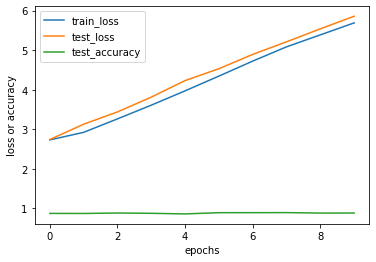

In [8]:
# lossのグラフ化
print(test_accuracy)
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
#              "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

## 重みをloadしてモデルに展開

In [9]:
model = CustomNN(input_dim=(1, 28, 28))

--------------------------------------------------
Layer			Output Shape
Input			[None, 1, 28, 28]
--------------------------------------------------
Conv0			[None, 16, 28, 28]
--------------------------------------------------
BatchNorm4D1		[None, 16, 28, 28]
--------------------------------------------------
Relu2			[None, 16, 28, 28]
--------------------------------------------------
Conv3			[None, 16, 28, 28]
--------------------------------------------------
BatchNorm4D4		[None, 16, 28, 28]
--------------------------------------------------
Relu5			[None, 16, 28, 28]
--------------------------------------------------
MaxPool6		[None, 16, 14, 14]
--------------------------------------------------
Conv7			[None, 32, 14, 14]
--------------------------------------------------
BatchNorm4D8		[None, 32, 14, 14]
--------------------------------------------------
Relu9			[None, 32, 14, 14]
--------------------------------------------------
Conv10			[None, 32, 14, 14]
-----------------------

In [10]:
with open("params.pickle", "rb") as f:
    params = pickle.load(f)

In [11]:
# print(model.trainLayers)
for idx, (key, layer) in enumerate(model.layers.items()):
    """
    idx:何番目の層か
    """
    # print(key)
    if idx in model.trainLayers:
        if "BatchNorm" in key:
#             print("BatchNorm update")
            layer.dgamma = params['W' + str(idx)]
            layer.dbeta = params['b' + str(idx)]
            layer.moving_mean = params["MM"+str(idx)]
            layer.moving_var = params["MV"+str(idx)]
#             print(params["MM"+str(idx)])
#             print(layer.moving_mean)
#             print(layer.moving_var)
            model.params['W' + str(idx)] = params['W' + str(idx)]
            model.params['b' + str(idx)] = params['b' + str(idx)]
            model.params["MM"+str(idx)] = params["MM"+str(idx)]
            model.params["MV"+str(idx)] = params["MV"+str(idx)]
        else:
            layer.W = params['W' + str(idx)]
            layer.b = params['b' + str(idx)]
            model.params['W' + str(idx)] = params['W' + str(idx)]
            model.params['b' + str(idx)] = params['b' + str(idx)]
            
# print(model.params)

## テスト

In [12]:
accuracy = model.accuracy(X_test, y_test)
loss  = model.loss(X_test, y_test)

accuracy, loss

(0.8532916666666667, 2.8999423254863608)